# Разработка решения, которое позволит уменьшить отток сотрудников из компании.
Компания предоставила данные с характеристиками сотрудников компании. Среди них — уровень удовлетворённости сотрудника работой в компании. Эту информацию получили из форм обратной связи: сотрудники заполняют тест-опросник, и по его результатам рассчитывается доля их удовлетворённости от 0 до 1, где 0 — совершенно неудовлетворён, 1 — полностью удовлетворён. 
Нам предстоит решить две задачи:
1. Разработать модель, которая сможет предсказать уровень удовлетворённости сотрудника на основе данных заказчика. 
2. Разработать модель, которая сможет на основе данных заказчика предсказать то, что сотрудник уволится из компании.



## Задача 1: предсказание уровня удовлетворённости сотрудника
Необходимо изучить данные и обучить две модели МО и выбрать лучшую для предсказания целевого признака уровня удовлетворённости сотрудником работой в компании, по скольку это числовое значение то это будет задача регрессии.

In [1]:
!pip install phik -q
!pip install shap -q

In [2]:
!pip install scikit-learn -q

In [3]:
!pip install -U scikit-learn -q

In [4]:
import shap
import seaborn as sns
from scipy import stats as st
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
import numpy as np
import pandas as pd 
from pandas import DataFrame
import random
import numpy
from matplotlib import pyplot 
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score,
    mean_absolute_error,
    confusion_matrix, 
    r2_score,
    precision_score,
    recall_score
)

import seaborn as sns
import math
import matplotlib.colors as colors
import matplotlib.cm as cmx
import matplotlib.pyplot as plt
from scipy import stats as st
import phik
from sklearn.model_selection import RandomizedSearchCV
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler, MinMaxScaler, RobustScaler,LabelEncoder 
from sklearn.pipeline import Pipeline
from matplotlib.pyplot import figure
from sklearn.metrics import roc_auc_score
from sklearn.metrics import make_scorer
from sklearn.tree import DecisionTreeRegressor

### Шаг 1. Загрузка данных
Загрузим таблицы с данными и проверим данные на пропуски дубликаты и прочие ошибки.

#### Данные тренировочной выборки:

In [5]:
train_job = pd.read_csv('/datasets/train_job_satisfaction_rate.csv')
train_job_column_names = train_job.columns.tolist()
for a in train_job_column_names:
    print('колличество пропусков в столбце -',a)
    print(train_job[a].isna().sum())
    print('---------------')
print(train_job.info())
train_job

колличество пропусков в столбце - id
0
---------------
колличество пропусков в столбце - dept
6
---------------
колличество пропусков в столбце - level
4
---------------
колличество пропусков в столбце - workload
0
---------------
колличество пропусков в столбце - employment_years
0
---------------
колличество пропусков в столбце - last_year_promo
0
---------------
колличество пропусков в столбце - last_year_violations
0
---------------
колличество пропусков в столбце - supervisor_evaluation
0
---------------
колличество пропусков в столбце - salary
0
---------------
колличество пропусков в столбце - job_satisfaction_rate
0
---------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     4000 non-null   int64  
 1   dept                   3994 non-null   object 
 2   level                  3996 non-

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate
0,155278,sales,junior,medium,2,no,no,1,24000,0.58
1,653870,hr,junior,high,2,no,no,5,38400,0.76
2,184592,sales,junior,low,1,no,no,2,12000,0.11
3,171431,technology,junior,low,4,no,no,2,18000,0.37
4,693419,hr,junior,medium,1,no,no,3,22800,0.20
...,...,...,...,...,...,...,...,...,...,...
3995,457950,technology,junior,high,2,no,no,3,46800,0.45
3996,957499,sales,junior,medium,2,no,no,4,21600,0.68
3997,533318,sales,middle,low,7,no,no,5,24000,0.76
3998,706868,sales,junior,medium,2,no,no,3,24000,0.48


Проверим столбец id на дубликаты, ведь только в нём их наличие недопустимо.

In [6]:
train_job['id'].duplicated().sum()

0

Всего в датасете 4000 строк, 10 столбцов, все столбцы обладают правильным типом данных. 

Есть 4 пропуска в столбце level, не буду их заполнять, ведь не ясно чем их заполнить, и всего 4 пропуска не повлияют на качество данных с 4000 записей.

Дубликатов в столбце с id не обнаружено.

#### Входные признаки тестовой выборки:

In [7]:
test_features = pd.read_csv('/datasets/test_features.csv')
test_features_column_names = test_features.columns.tolist()
for a in test_features_column_names:
    print('колличество пропусков в столбце -',a)
    print(test_features[a].isna().sum())
    print('---------------')
print(test_features.info())
test_features

колличество пропусков в столбце - id
0
---------------
колличество пропусков в столбце - dept
2
---------------
колличество пропусков в столбце - level
1
---------------
колличество пропусков в столбце - workload
0
---------------
колличество пропусков в столбце - employment_years
0
---------------
колличество пропусков в столбце - last_year_promo
0
---------------
колличество пропусков в столбце - last_year_violations
0
---------------
колличество пропусков в столбце - supervisor_evaluation
0
---------------
колличество пропусков в столбце - salary
0
---------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 9 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   id                     2000 non-null   int64 
 1   dept                   1998 non-null   object
 2   level                  1999 non-null   object
 3   workload               2000 non-null   object
 4   employmen

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary
0,485046,marketing,junior,medium,2,no,no,5,28800
1,686555,hr,junior,medium,1,no,no,4,30000
2,467458,sales,middle,low,5,no,no,4,19200
3,418655,sales,middle,low,6,no,no,4,19200
4,789145,hr,middle,medium,5,no,no,5,40800
...,...,...,...,...,...,...,...,...,...
1995,393147,marketing,junior,low,3,no,no,3,20400
1996,109582,technology,middle,low,3,no,no,2,21600
1997,305653,technology,junior,low,1,no,no,3,14400
1998,160233,technology,middle,low,8,no,no,1,32400


In [8]:
test_features['id'].duplicated().sum()

0

Всего в датасете 2000 строк, 9 столбцов, все столбцы обладают правильным типом данных. 

Есть 2 пропуска в столбце debt, и 1 в столбцу level.

Дубликатов в столбце с id не обнаружено.

#### Целевой признак тестовой выборки:

In [9]:
test_target_job = pd.read_csv('/datasets/test_target_job_satisfaction_rate.csv')
print(test_target_job.isna().sum())
print(test_target_job.duplicated().sum())
test_target_job

id                       0
job_satisfaction_rate    0
dtype: int64
0


,id,job_satisfaction_rate
0,130604,0.74
1,825977,0.75
2,418490,0.60
3,555320,0.72
4,826430,0.08
...,...,...
1995,405257,0.28
1996,370925,0.21
1997,857722,0.39
1998,303402,0.26


Дубликатов и пропусков не обнаружено.

Я просмотрел все датасеты, пропусков практически нет в каждом датасете, дубликатов нет, все столбцы совпадают своиму типу данных.

### Шаг 2. Предоработка данных
Удалим пропуски при помощи пайплайна

In [10]:
_1st_pipeline = Pipeline(
    [('simpleImputer_1', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
     ('simpleImputer_2', SimpleImputer(missing_values=' ', strategy='most_frequent'))
    ]
    )

_1st_pipeline1 = Pipeline(
    [('simpleImputer_1', SimpleImputer(missing_values='sales', strategy='most_frequent')),
    ]
    )

train_job['dept'] = _1st_pipeline.fit_transform(pd.DataFrame(train_job['dept']))
test_features['dept'] = _1st_pipeline.transform(pd.DataFrame(test_features['dept']))
train_job['level'] = _1st_pipeline.fit_transform(pd.DataFrame(train_job['level']))
test_features['level'] = _1st_pipeline.transform(pd.DataFrame(test_features['level']))
test_features['level'] = _1st_pipeline1.fit_transform(pd.DataFrame(test_features['level']))
train_job['workload'] = _1st_pipeline.fit_transform(pd.DataFrame(train_job['workload']))
test_features['workload'] = _1st_pipeline.transform(pd.DataFrame(test_features['workload']))

Пропуски устранены

### Шаг 3. Исследовательский анализ данных

Проведём анализ данных при помощи визуализации графиками и учитывая данные анализа выясним как данные необходимо подготовить для дальнейшей работы с ними

#### Данные тренировочной выборки:

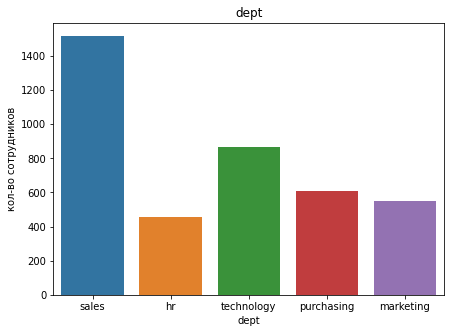

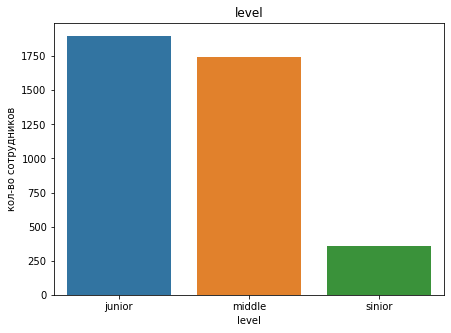

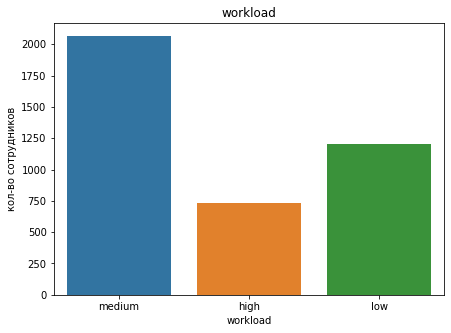

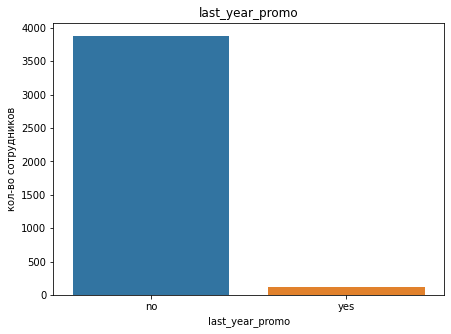

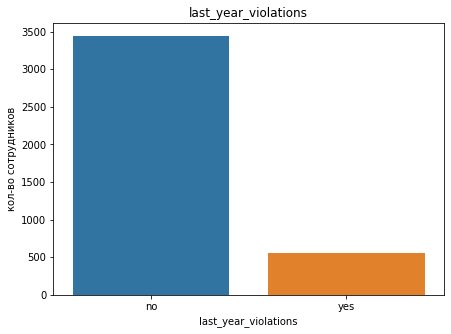

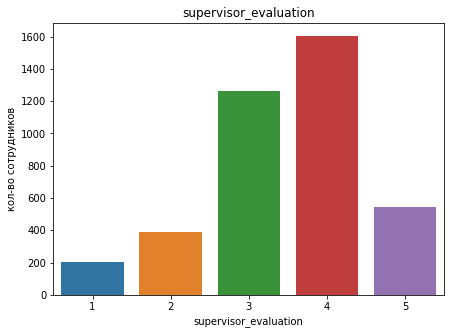

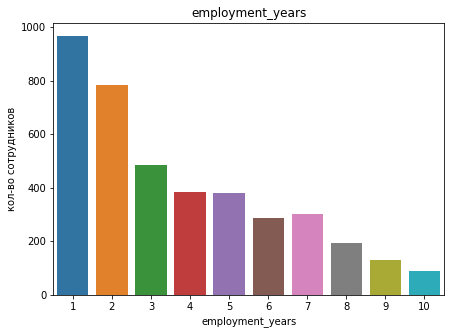

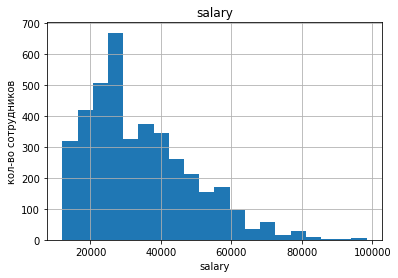

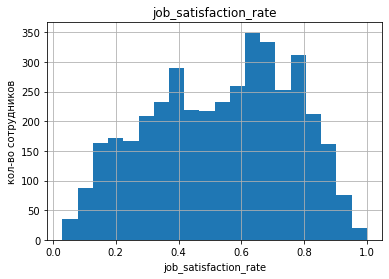

In [11]:
train_job_column_names_1 = ['dept','level','workload','last_year_promo','last_year_violations','supervisor_evaluation','employment_years',]
train_job_column_names_2 = ['salary','job_satisfaction_rate']
for j in train_job_column_names_1:
    plt.figure(figsize=(7, 5))
    fig = sns.countplot(x =j, data = train_job)
    fig.set_title(j)
    fig.set_xlabel(j)
    fig.set_ylabel('кол-во сотрудников')
    plt.show()
for i in train_job_column_names_2:
    train_job.hist(column=i, bins=20)
    plt.title(i)
    plt.xlabel(i)
    plt.ylabel('кол-во сотрудников')
    plt.show()    

Text(0, 0.5, 'зарплата')

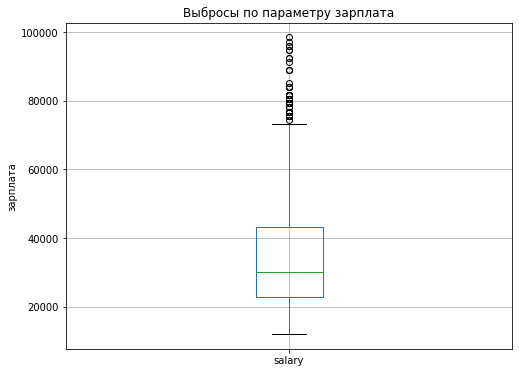

In [12]:
fig = plt.figure(figsize=(8,6))
ax = fig.gca()
train_job.boxplot(column='salary', ax=ax)
ax.set_title('Выбросы по параметру зарплата')
ax.set_ylabel('зарплата')

#### Корреляция признаков
Построим матрицу корреляции.

In [13]:
train_job_for_matrix = train_job.drop(['id'],axis = 1)
train_job_for_matrix.phik_matrix(interval_cols = ['salary','job_satisfaction_rate'])

,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate
dept,1.000000,0.000000,0.016542,0.036815,0.000000,0.000000,0.105706,0.282657,0.082659
level,0.000000,1.000000,0.419591,0.682962,0.101668,0.000000,0.000000,0.717761,0.080753
workload,0.016542,0.419591,1.000000,0.181941,0.058663,0.000000,0.037023,0.788820,0.056128
employment_years,0.036815,0.682962,0.181941,1.000000,0.183579,0.056808,0.000000,0.483419,0.325603
last_year_promo,0.000000,0.101668,0.058663,0.183579,1.000000,0.000000,0.013681,0.215025,0.190803
last_year_violations,0.000000,0.000000,0.000000,0.056808,0.000000,1.000000,0.182042,0.010078,0.560348
supervisor_evaluation,0.105706,0.000000,0.037023,0.000000,0.013681,0.182042,1.000000,0.000000,0.764364
salary,0.282657,0.717761,0.788820,0.483419,0.215025,0.010078,0.000000,1.000000,0.165830
job_satisfaction_rate,0.082659,0.080753,0.056128,0.325603,0.190803,0.560348,0.764364,0.165830,1.000000


Параметр level имеет сильную корреляцию с параметрами employment_years и salary, параметр salary сильно коррелирует не только с level но и с workload(что логично), employment_years средне коррелирует с salary, job_satisfaction_rate сильно коррелирует с supervisor_evaluation.

#### Выявленные закономернности

Больше всего сотрудников работает в отжеде по продажам, на втором месте по кол-ву сотрудников отдел технологии, меньше всего сотрудников в hr отделе.

В компании больше всего джунов и миддлов, меньше всего сеньёров.

БОльшая часть сотрудников загружена средне, меньше сотрудников загружены слабо и меньше всего в компании сотрудников с высокой нагрузкой.

За последний год повышей в компании почти не было.

За последний год очень небольшая часть сотрудников совершала нарушения трудового договора.

БОльшая часть сотрудников оценена их руководителями на 4 и 3, меньше всего сотрудников с оценкой 1.

БОльшая часть сотрудников работает в компании год либо 2.

БОльшая часть сотрудников получает зарплату в районе 30 тыс. в месяц, очень небольшая часть зарплат больше 60 тысяч.

В основном сотрудники оценивают качесвто труда в 0.7


#### Входные признаки тестовой выборки:

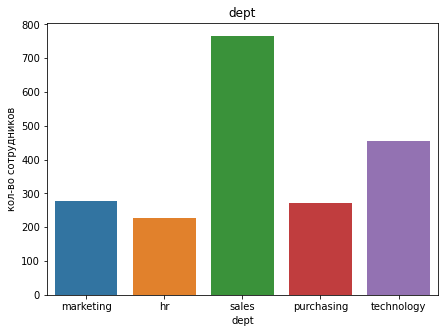

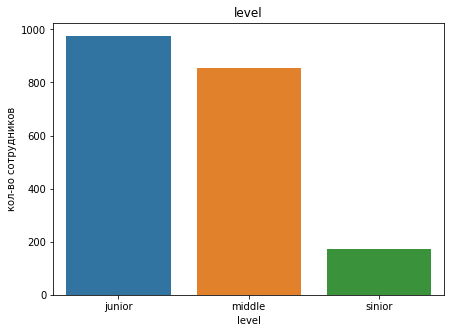

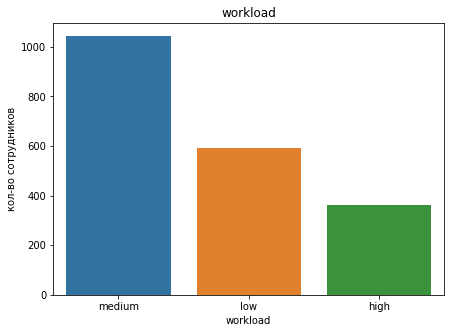

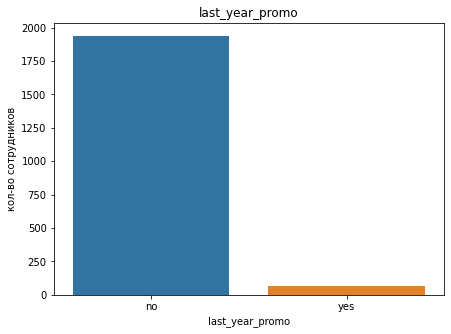

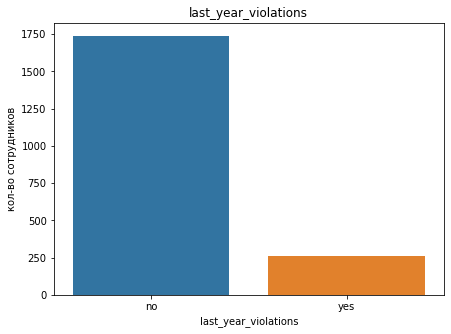

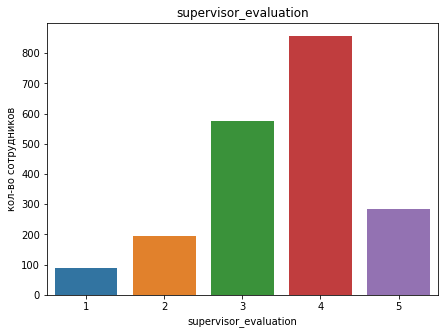

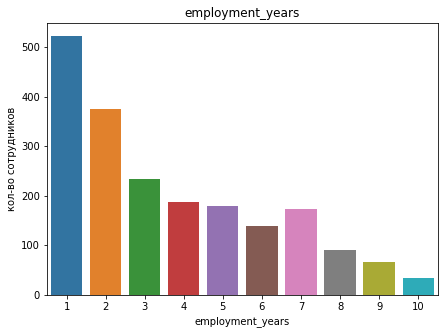

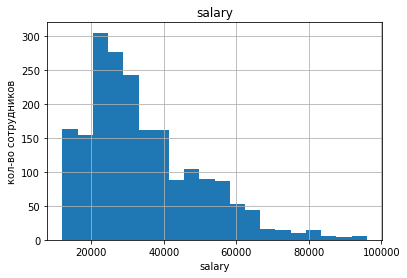

In [14]:
train_job_column_names_2.pop(-1)
for j in train_job_column_names_1:
    plt.figure(figsize=(7, 5))
    fig = sns.countplot(x =j, data = test_features)
    fig.set_title(j)
    fig.set_xlabel(j)
    fig.set_ylabel('кол-во сотрудников')
    plt.show()  
for i in train_job_column_names_2:
    test_features.hist(column=i, bins=20)
    plt.title(i)
    plt.xlabel(i)
    plt.ylabel('кол-во сотрудников')
    plt.show()    

Данные по всем параметрам распределены примерно также как у тренеровочной выборки.

In [15]:
test_features_for_matrix = test_features.drop(['id'],axis = 1)
test_features_for_matrix.phik_matrix(interval_cols = ['salary'])

,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary
dept,1.000000,0.000000,0.030720,0.000000,0.000000,0.000000,0.058630,0.330057
level,0.000000,1.000000,0.474453,0.689747,0.118283,0.017551,0.000000,0.749068
workload,0.030720,0.474453,1.000000,0.202096,0.035565,0.000000,0.035920,0.785872
employment_years,0.000000,0.689747,0.202096,1.000000,0.173637,0.066371,0.000000,0.494701
last_year_promo,0.000000,0.118283,0.035565,0.173637,1.000000,0.000000,0.011704,0.193727
last_year_violations,0.000000,0.017551,0.000000,0.066371,0.000000,1.000000,0.189719,0.000000
supervisor_evaluation,0.058630,0.000000,0.035920,0.000000,0.011704,0.189719,1.000000,0.114588
salary,0.330057,0.749068,0.785872,0.494701,0.193727,0.000000,0.114588,1.000000


Корреляции те же что и у тренировочной выборки.

#### Целевой признак тестовой выборки:

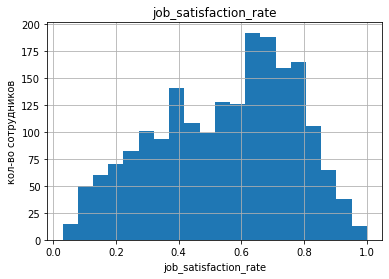

In [16]:
test_target_job.hist(column='job_satisfaction_rate', bins=20)
plt.title('job_satisfaction_rate')
plt.xlabel('job_satisfaction_rate')
plt.ylabel('кол-во сотрудников')
plt.show()    

Целевой признак распределён похожим образом на признак тренировочного датафрейма, но в райне 0.8 пик меньше.

### Шаг 4. Подготовка данных
Дополним первый пайплайн новыми шагами для преобразования данных чтобы с ними могла работать модель МО.

In [17]:
train_job_column_names.pop(0)
train_job_column_names.pop(-1)

'job_satisfaction_rate'

In [18]:
train_job

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate
0,155278,sales,junior,medium,2,no,no,1,24000,0.58
1,653870,hr,junior,high,2,no,no,5,38400,0.76
2,184592,sales,junior,low,1,no,no,2,12000,0.11
3,171431,technology,junior,low,4,no,no,2,18000,0.37
4,693419,hr,junior,medium,1,no,no,3,22800,0.20
...,...,...,...,...,...,...,...,...,...,...
3995,457950,technology,junior,high,2,no,no,3,46800,0.45
3996,957499,sales,junior,medium,2,no,no,4,21600,0.68
3997,533318,sales,middle,low,7,no,no,5,24000,0.76
3998,706868,sales,junior,medium,2,no,no,3,24000,0.48


In [19]:
class DataframeFunctionTransformer():
    def __init__(self, func):
        self.func = func

    def transform(self, input_df, **transform_params):
        return self.func(input_df)

    def fit(self, X, y=None, **fit_params):
        return self
    
def framer1(a):
    a = pd.DataFrame(a)
    return a    


num_columns = ['salary']
ohe_columns = ['dept','last_year_promo','last_year_violations']
ord_columns = [ 'level', 'workload']
ohe_pipe = Pipeline(
    [('simpleImputer_ohe', SimpleImputer(missing_values=np.nan,strategy='most_frequent')),
     ('ohe', OneHotEncoder(drop='first',handle_unknown = 'ignore',sparse_output=False)),

    ]
    )
num_pipe = Pipeline(
    [('stanart', StandardScaler()),
     ('minmax',MinMaxScaler())
    ]
    )

ord_pipe = Pipeline([('ord',OrdinalEncoder(handle_unknown='use_encoded_value',unknown_value = 1337))])
_2nd_pipeline = ColumnTransformer(
    [
     ('ohe', ohe_pipe, ohe_columns),
     ('num', num_pipe, num_columns),
     ('ord',ord_pipe,ord_columns)
    ], 
    remainder='passthrough'
)
_3rd_pipeline = Pipeline(
    [('1',_2nd_pipeline),
     ('frame', DataframeFunctionTransformer(framer1))
    ])

zz = _3rd_pipeline.fit_transform(train_job)
zz

,0,1,2,3,4,5,6,7,8,9,10,11,12
0,0.0,0.0,1.0,0.0,0.0,0.0,0.138889,0.0,2.0,155278.0,2.0,1.0,0.58
1,0.0,0.0,0.0,0.0,0.0,0.0,0.305556,0.0,0.0,653870.0,2.0,5.0,0.76
2,0.0,0.0,1.0,0.0,0.0,0.0,0.000000,0.0,1.0,184592.0,1.0,2.0,0.11
3,0.0,0.0,0.0,1.0,0.0,0.0,0.069444,0.0,1.0,171431.0,4.0,2.0,0.37
4,0.0,0.0,0.0,0.0,0.0,0.0,0.125000,0.0,2.0,693419.0,1.0,3.0,0.20
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3995,0.0,0.0,0.0,1.0,0.0,0.0,0.402778,0.0,0.0,457950.0,2.0,3.0,0.45
3996,0.0,0.0,1.0,0.0,0.0,0.0,0.111111,0.0,2.0,957499.0,2.0,4.0,0.68
3997,0.0,0.0,1.0,0.0,0.0,0.0,0.138889,1.0,1.0,533318.0,7.0,5.0,0.76
3998,0.0,0.0,1.0,0.0,0.0,0.0,0.138889,0.0,2.0,706868.0,2.0,3.0,0.48


Данные преобразованы.

### Шаг 5. Обучение моделей
Обучим две модели МО для предсказания целевого признака и определим лучшую по метрике SMAPE.
Для этого инициализируем модели в поиске по сетке и напишем собственную метрику SMAPE.

In [20]:
test_features = test_features.sort_values('id')
test_target_job = test_target_job.sort_values('id')

In [21]:
RANDOM_STATE = 42
X_train = train_job.drop(['id','job_satisfaction_rate'],axis = 1)
y_train = train_job['job_satisfaction_rate']

In [22]:
X_test = test_features.drop(['id'],axis = 1)
y_test = test_target_job['job_satisfaction_rate']

In [23]:
pipe_special= Pipeline([
    ('preprocessor', _2nd_pipeline),
    ('models', LinearRegression())
    
])

In [24]:
param_grid = [
    {
        'models': [DecisionTreeRegressor(random_state=RANDOM_STATE)],
        'models__max_depth': range(90,120),
        'models__max_features': range(50,100),
        'preprocessor__ohe': [OneHotEncoder(), OrdinalEncoder()],
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']
           
    },
    {
        'models': [LinearRegression()],
        'preprocessor__ohe': [OrdinalEncoder(),OneHotEncoder()],
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough'],  
    }
]

In [25]:
def smape(y_true,y_pred):
    n = len(y_pred)
    smape1 = (100/n)*sum(abs(y_true-y_pred)/((abs(y_true)+abs(y_pred))/2))
    return smape1
smape2 = make_scorer(smape,greater_is_better=False)  

In [26]:
randomized_search = RandomizedSearchCV(
    pipe_special, 
    param_grid, 
    cv=5,
    scoring=smape2,
    random_state=42,
    n_jobs=-1
)
randomized_search.fit(X_train, y_train)
grid_result = randomized_search.fit(X_train, y_train)

print('Лучшая модель и её параметры:\n\n', randomized_search.best_estimator_)
print ('Метрика SMAPE для лучшей модели:', randomized_search.best_score_)

Лучшая модель и её параметры:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe', OneHotEncoder(),
                                                  ['dept', 'last_year_promo',
                                                   'last_year_violations']),
                                                 ('num', MinMaxScaler(),
                                                  ['salary']),
                                                 ('ord',
                                                  Pipeline(steps=[('ord',
                                                                   OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                                  unknown_value=1337))]),
                                                  ['level', 'workload'])])),
                ('models',
                 DecisionTreeRegressor(max_depth=92

Для сравнения я выбрал две модели это дерево классификатор и модель линейной регрессии, лучшей из них оказалась модель 'дерева' 
с метрикой SMAPE равной -15.25

Протестируем модель

In [27]:
y_pred = randomized_search.best_estimator_.predict(X_test)
y_true = y_test
print('Метрика SMAPE для тестовой выборки равна:')
(smape(y_pred,y_true))

Метрика SMAPE для тестовой выборки равна:


14.6047318137211

### Шаг 6. Выводы

В нашем эксперементе лучшей моделью оказалась DecisionTreeClassifier c метрикой равной -15.25, она лучше справилась с задачей регрессии, ведь видимо в данных есть не прямые корреляции между признаками и из-за этого линейная регрессия справилась хуже.

## Задача 2: предсказание увольнения сотрудника из компании
Для решения этой задачи необходимо проделать все те же шаги как и для предыдущей, только теперь модель должна будет предсказать не число а принадлежность обьекта к одному из двух классов целевого признака "уйдёт сотрудник или нет", то есть это будет задача бинарной классификкации. 

### Шаг 1. Загрузка данных
загрузим таблицу с новым целевым признаком

In [28]:
train_quit = pd.read_csv('/datasets/train_quit.csv')
train_quit_column_names = train_quit.columns.tolist()
for g in train_quit_column_names:
    print('колличество пропусков в столбце -',g)
    print(train_quit[g].isna().sum())
    print('---------------')
print(train_quit.info())
train_quit

колличество пропусков в столбце - id
0
---------------
колличество пропусков в столбце - dept
0
---------------
колличество пропусков в столбце - level
0
---------------
колличество пропусков в столбце - workload
0
---------------
колличество пропусков в столбце - employment_years
0
---------------
колличество пропусков в столбце - last_year_promo
0
---------------
колличество пропусков в столбце - last_year_violations
0
---------------
колличество пропусков в столбце - supervisor_evaluation
0
---------------
колличество пропусков в столбце - salary
0
---------------
колличество пропусков в столбце - quit
0
---------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   id                     4000 non-null   int64 
 1   dept                   4000 non-null   object
 2   level                  4000 non-null   object
 3   wo

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,quit
0,723290,sales,middle,high,2,no,no,4,54000,no
1,814010,sales,junior,medium,2,no,no,4,27600,no
2,155091,purchasing,middle,medium,5,no,no,1,37200,no
3,257132,sales,junior,medium,2,no,yes,3,24000,yes
4,910140,marketing,junior,medium,2,no,no,5,25200,no
...,...,...,...,...,...,...,...,...,...,...
3995,588809,sales,junior,medium,4,no,no,3,26400,no
3996,672059,sales,middle,high,9,no,no,4,52800,no
3997,536432,purchasing,junior,low,2,no,yes,4,12000,yes
3998,692133,purchasing,middle,medium,2,no,no,4,33600,no


In [29]:
test_target_quit = pd.read_csv('/datasets/test_target_quit.csv')
print(test_target_quit.info())
test_target_quit

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      2000 non-null   int64 
 1   quit    2000 non-null   object
dtypes: int64(1), object(1)
memory usage: 31.4+ KB
None


,id,quit
0,999029,yes
1,372846,no
2,726767,no
3,490105,no
4,416898,yes
...,...,...
1995,836109,yes
1996,180999,yes
1997,746018,no
1998,247658,no


In [30]:
print(test_target_quit.isna().sum())
print(test_target_quit.duplicated().sum())

id      0
quit    0
dtype: int64
0


Данные загружены

Пропуски и дубликаты не обнаружены.

### Шаг 2. Исследовательский анализ данных
Составим портрет "уволившегося" сотрудника, сравнив уровни зарплат и загруженности, и то в каком отделе больше увольнений.

Также аналитики утверждают, что уровень удовлетворённости сотрудника работой в компании влияет на то, уволится ли сотрудник.
Для проверки этого утверждения визуализируем и сравним распределения признака job_satisfaction_rate для ушедших и оставшихся сотрудников в тестовой выборке с обоими целевыми признаками.

### Данные тренировочной выборки

Взглянем на новый признак

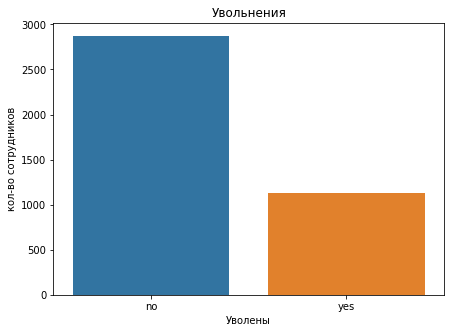

In [31]:
plt.figure(figsize=(7, 5))
fig = sns.countplot(x ='quit', data = train_quit)
fig.set_title('Увольнения')
fig.set_xlabel('Уволены')
fig.set_ylabel('кол-во сотрудников')
plt.show()

Суммарно Увольнений произошло почти как половина текущего штата.

### Целевой признак тестовой выборки

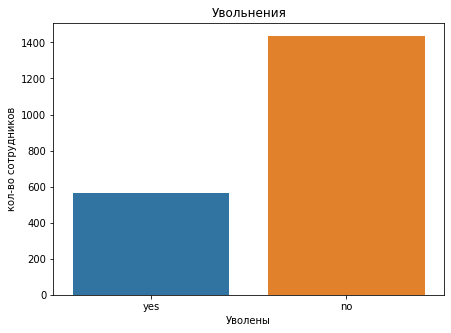

In [32]:
plt.figure(figsize=(7, 5))
fig = sns.countplot(x ='quit', data = test_target_quit)
fig.set_title('Увольнения')
fig.set_xlabel('Уволены')
fig.set_ylabel('кол-во сотрудников')
plt.show()

В тестовых данных картина похожая.

### Портрет уволенного сотрудника 
Построим столбчатые диаграммы и сравним уровень увольнений.

In [33]:
type9 = train_quit.groupby(['dept','quit']).count()
type9 = type9['id'].reset_index()
type9

,dept,quit,id
0,hr,no,348
1,hr,yes,116
2,marketing,no,419
3,marketing,yes,163
4,purchasing,no,422
5,purchasing,yes,166
6,sales,no,1031
7,sales,yes,407
8,technology,no,652
9,technology,yes,276


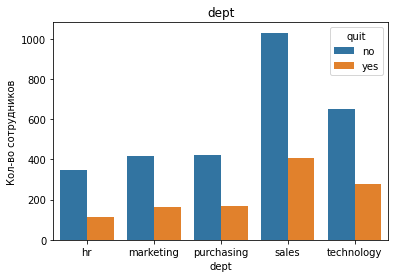

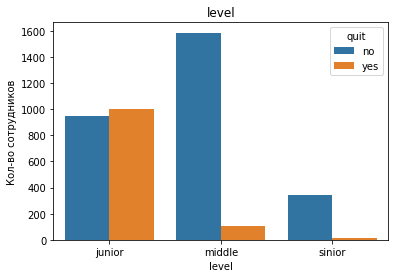

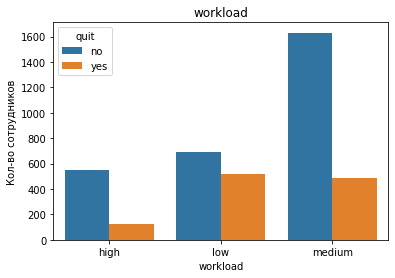

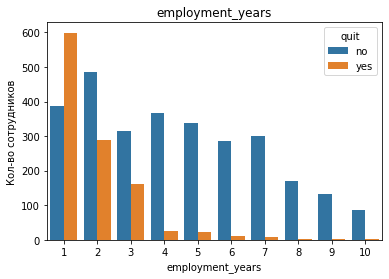

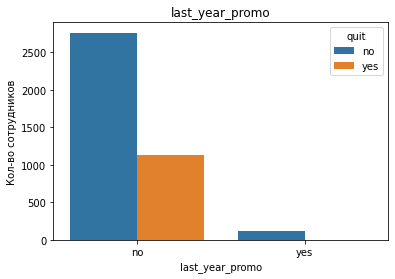

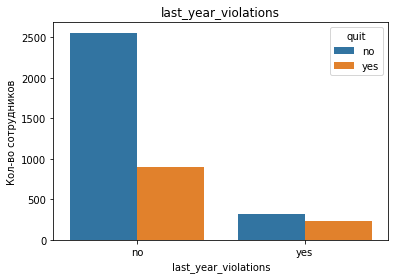

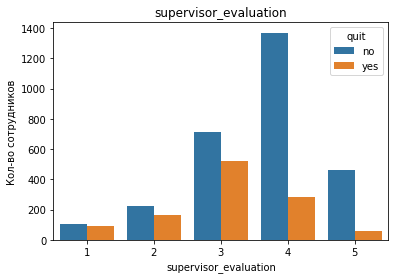

In [34]:
train_quit_columns = ['dept','level','workload','employment_years','last_year_promo','last_year_violations','supervisor_evaluation']

for h in train_quit_columns:
    type9 = train_quit.groupby([h,'quit']).count()
    type9 = type9['id'].reset_index()
    sns.barplot(x = h, y = 'id',hue = 'quit' ,data = type9)
    plt.title(h)
    plt.ylabel('Кол-во сотрудников')
    plt.show()

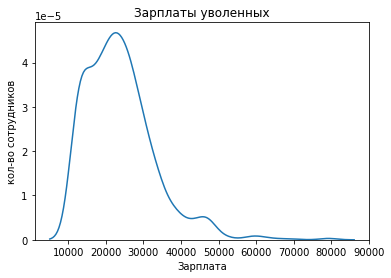

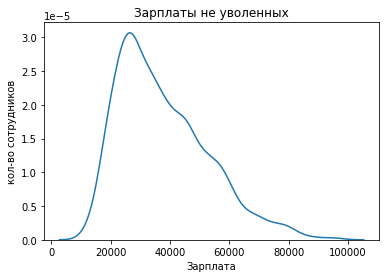

In [35]:
xx = train_quit.query('quit == "yes"')
yy = train_quit.query('quit == "no"')
fig = sns.kdeplot(xx.salary)
fig.set_title('Зарплаты уволенных')
fig.set_xlabel('Зарплата')
fig.set_ylabel('кол-во сотрудников')
plt.show()
fig = sns.kdeplot(yy.salary)
fig.set_title('Зарплаты не уволенных')
fig.set_xlabel('Зарплата')
fig.set_ylabel('кол-во сотрудников')
plt.show()

Самый высокий уровень увольнений в отделе технологий - это 0.42 и в отделе продаж это 0.39,  , очень много увольняется джунов, чаще увольняются сотрудники с низким уровнем нагрузки и проработавшие всего год, чаще увольняются сотрудники с оценкой от руководителя 3 и ниже и с зарплатой ниже 50 тысяч.

### Проверка утверждения аналитиков

In [36]:
test_target_quit_1 = test_target_quit
test_target_quit_1['job_satisfaction_rate'] =  randomized_search.predict(X_test)
train_quit['job_satisfaction_rate'] = randomized_search.predict(X_train)

In [37]:
test_target_quit_1['job_satisfaction_rate'] = test_target_quit_1['job_satisfaction_rate'].astype('float')

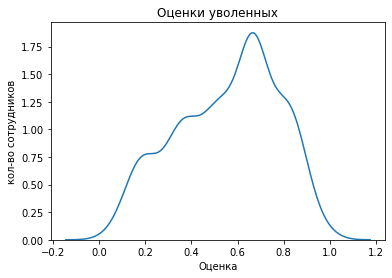

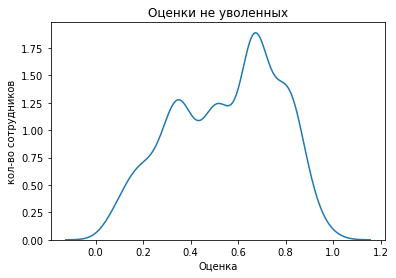

In [38]:
xx1 = test_target_quit_1.query('quit == "yes"')
yy1 = test_target_quit_1.query('quit == "no"')
fig = sns.kdeplot(xx1.job_satisfaction_rate)
fig.set_title('Оценки уволенных')
fig.set_xlabel('Оценка')
fig.set_ylabel('кол-во сотрудников')
plt.show()
fig = sns.kdeplot(yy1.job_satisfaction_rate)
fig.set_title('Оценки не уволенных')
fig.set_xlabel('Оценка')
fig.set_ylabel('кол-во сотрудников')
plt.show()

Если посмотреть на граффики плотности, то станет видно оценки уволенных и не уволенных сотрудников распределены одинаково, значит утверждение аналитиков возможно не верно.

### Шаг 4. Добавление нового входного признака
Допустим, job_satisfaction_rate и quit действительно связаны и мы получили необходимое значение метрики в первой задаче. Тогда добавьте job_satisfaction_rate, предсказанный лучшей моделью первой задачи, к входным признакам второй задачи.

In [39]:

job_satisfaction_rate2 = randomized_search.predict(X_test)
test_features['job_satisfaction_rate'] = job_satisfaction_rate2
test_features

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate
1172,100298,hr,junior,low,2,no,no,4,19200,0.820000
852,100480,marketing,junior,low,4,no,no,4,16800,0.850000
848,100503,purchasing,middle,high,5,no,no,4,55200,0.770000
524,100610,sales,middle,medium,5,no,no,4,43200,0.813333
476,100692,sales,middle,high,6,no,no,4,48000,0.697500
...,...,...,...,...,...,...,...,...,...,...
1925,997290,sales,sinior,medium,7,no,no,4,58800,0.790000
1886,998548,marketing,junior,medium,2,no,no,4,32400,0.790000
506,998762,technology,junior,low,3,no,no,3,22800,0.505000
1579,998900,marketing,middle,medium,7,no,no,3,45600,0.430000


In [40]:
train_quit['job_satisfaction_rate'] = randomized_search.predict(X_train)
train_quit

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,quit,job_satisfaction_rate
0,723290,sales,middle,high,2,no,no,4,54000,no,0.500000
1,814010,sales,junior,medium,2,no,no,4,27600,no,0.760000
2,155091,purchasing,middle,medium,5,no,no,1,37200,no,0.140000
3,257132,sales,junior,medium,2,no,yes,3,24000,yes,0.370000
4,910140,marketing,junior,medium,2,no,no,5,25200,no,0.176250
...,...,...,...,...,...,...,...,...,...,...,...
3995,588809,sales,junior,medium,4,no,no,3,26400,no,0.492500
3996,672059,sales,middle,high,9,no,no,4,52800,no,0.678571
3997,536432,purchasing,junior,low,2,no,yes,4,12000,yes,0.760000
3998,692133,purchasing,middle,medium,2,no,no,4,33600,no,0.516667


Новый входной признак добавлен.

### Шаг 5. Подготовка данных
Подготовим данные, чтобы с ними могли работать модели мо.Для этого дополним уже существующзий пайплайн.

In [41]:
num_columns1  = ['salary','job_satisfaction_rate']

In [42]:
ohe_columns
_4th_pipeline = ColumnTransformer(
    [('ohe', ohe_pipe, ohe_columns),
     ('num', num_pipe, num_columns1),
     ('ord',ord_pipe,ord_columns)
     
    ], 
    remainder='passthrough'
)
_5th_pipeline = Pipeline(
    [('1',_4th_pipeline),
     ('frame', DataframeFunctionTransformer(framer1))
    ])

vv = _5th_pipeline.fit_transform(train_quit)
vv

,0,1,2,3,4,5,6,7,8,9,10,11,12,13
0,0.0,0.0,1.0,0.0,0.0,0.0,0.5,0.484536,1.0,0.0,723290,2,4,no
1,0.0,0.0,1.0,0.0,0.0,0.0,0.185714,0.752577,0.0,2.0,814010,2,4,no
2,0.0,1.0,0.0,0.0,0.0,0.0,0.3,0.113402,1.0,2.0,155091,5,1,no
3,0.0,0.0,1.0,0.0,0.0,1.0,0.142857,0.350515,0.0,2.0,257132,2,3,yes
4,1.0,0.0,0.0,0.0,0.0,0.0,0.157143,0.150773,0.0,2.0,910140,2,5,no
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3995,0.0,0.0,1.0,0.0,0.0,0.0,0.171429,0.476804,0.0,2.0,588809,4,3,no
3996,0.0,0.0,1.0,0.0,0.0,0.0,0.485714,0.66863,1.0,0.0,672059,9,4,no
3997,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.752577,0.0,1.0,536432,2,4,yes
3998,0.0,1.0,0.0,0.0,0.0,0.0,0.257143,0.501718,1.0,2.0,692133,2,4,no


Данные преобразованы

### Шаг 6. Обучение моделей
Обучим модели в пайплайне и найдём лучшую при помощи gridsearch 

In [43]:
pipe_special1= Pipeline([
    ('preprocessor', _4th_pipeline),
    ('models', DecisionTreeClassifier(random_state=RANDOM_STATE))
    
])

In [44]:
X_train1 = train_quit.drop(['id','quit'],axis = 1)
X_test1 = test_features
y_train1 =  train_quit['quit']
y_test1 = test_target_quit['quit']

label_encoder = LabelEncoder()
label_encoder.fit(y_train1)

y_train1 = label_encoder.transform(y_train1)
y_test1 = label_encoder.transform(y_test1) 

In [45]:
param_grid1 = [
    {
        'models': [DecisionTreeClassifier(random_state=RANDOM_STATE)],
        'models__max_depth': range(6,20),
        'models__max_features': range(1,20),
        'preprocessor__ohe': [OneHotEncoder(), OrdinalEncoder()],
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']
           
    },
    
    {
        'models': [KNeighborsClassifier()],
        'models__n_neighbors': range(1,20),
        'preprocessor__ohe': [OneHotEncoder(), OrdinalEncoder()],
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough'],  
    },

    {
        'models': [LogisticRegression(
            random_state=RANDOM_STATE, 
            solver='liblinear', 
            penalty='l1'
        )],
        'models__C': range(1,20),
        'preprocessor__ohe': [OrdinalEncoder(),OneHotEncoder()],
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough'],  
    },
     {
        'models': [SVC(probability=True,random_state = RANDOM_STATE)],
        'models__C': range(1,20),
        'preprocessor__ohe': [OneHotEncoder(), OrdinalEncoder()],
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough'],  
    }
    
]

In [47]:
randomized_search1 = RandomizedSearchCV(
    pipe_special1, 
    param_grid1, 
    cv=5,
    scoring='roc_auc',
    random_state=42,
    n_jobs=-1
)
randomized_search1.fit(X_train1, y_train1)
grid_result = randomized_search1.fit(X_train1, y_train1)

print('Лучшая модель и её параметры:\n\n', randomized_search1.best_estimator_)
print ('Метрика лучшей модели на кросс валидации:', randomized_search1.best_score_)


Лучшая модель и её параметры:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe', OrdinalEncoder(),
                                                  ['dept', 'last_year_promo',
                                                   'last_year_violations']),
                                                 ('num', MinMaxScaler(),
                                                  ['salary',
                                                   'job_satisfaction_rate']),
                                                 ('ord',
                                                  Pipeline(steps=[('ord',
                                                                   OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                                  unknown_value=1337))]),
                                                  ['level', 'workload'])])),
 

Лучшей моделью оказалась логистическая регрессия с метрикой roc auc = 0.918

### Шаг 7. Выводы

С нашей задачей лучше всего справилась модель логистической регрессии, ведь задача заключалась в бинарной классификации и эта модель хорошо подходит для данных без выбросов, собственно такие данные у нас и были.

## Общий вывод

Передо мной стояла задача разработать решение которое уменьшит отток сотрудников из компании, а именно обучить две модели машинного обучения для предсказания оценки сотрудником условий труда и того уйдёт ли сотрудник, и выявить портрет уволенного сотрудника, чтобы дать компании советы по удержанию кадров.

Решение подзадачи №1:

Для начала я загрузил данные и проверил их на пропуски с дубликатами, в датасетах оказалось 1-2 пропуска в столбцах level и dept,чтобы заполнить их я составил пайплайнв котором в дальнейшем и прописал всю преподготовку для данных.

На этапе первичного исследовательского анализа датасетов, я выявил следующие особенности коллектива в компании:

Больше всего сотрудников работает в отжеде по продажам, на втором месте по кол-ву сотрудников отдел технологии, меньше всего сотрудников в hr отделе.

В компании больше всего джунов и миддлов, меньше всего сеньёров.

БОльшая часть сотрудников загружена средне, меньше сотрудников загружены слабо и меньше всего в компании сотрудников с высокой нагрузкой.

За последний год повышей в компании почти не было.

За последний год очень небольшая часть сотрудников совершала нарушения трудового договора.

БОльшая часть сотрудников оценена их руководителями на 4 и 3, меньше всего сотрудников с оценкой 1.

БОльшая часть сотрудников работает в компании год либо 2.

БОльшая часть сотрудников получает зарплату в районе 30 тыс. в месяц, очень небольшая часть зарплат больше 60 тысяч.

В основном сотрудники оценивают качесвто труда в 0.7


После этого я дополнил ранее написанный пайплайн, добавив в него шаги по преобразованию категориальных признаков и шаг по масштабированию колличественных признаков.

Далее я обучил две модели МО - Дерево и Линейную регрессию, и выбрал из них лучшую при помощи метрики SMAPE то есть «симметричное среднее абсолютное процентное отклонение», для этого я имплиминтировал в поиск по сетке собственную метрику инициализированную через make scorer, и после этого лучшей моделью оказалось Дерево с метрикой равной -15.25, она лучше справилась с задачей регрессии, ведь видимо в данных есть не прямые корреляции между признаками и из-за этого линейная регрессия справилась хуже.

Решение подзадачи №2:

Я также загрузил данные с новым целевым признаком quit, в новы датасетах ни оказалось пропусков и дубликатов по этому этапа предоработки не было.

Дальше я занялся исследовательским анализом для того чтобы выявить портрет уволенного сотрудника, для этого я сравнил кол-во увольнений в разных отделах и увольнения сотрудников разным размером зарплаты и с разной загрузкой и т.д.

Портрет получился такой:

Это сотрудник из отдела технологий, с уровнем знаний джуниор, с низким уровнем загрузки, который проработал год и меньше, с оценкой от руководителя 3 и ниже и зарплатой ниже 50 тысяч.

Также аналитики утверждали что оценка сотрудником уролвня труда на прямую зависит на то уйдёт ли он из компании или нет, я првоерил эту гипотезу сравнив кол-во увольнений с разными оценками труда и оказалось что аналитики по большей части правы, ведь если взглянуть на увольнения сотрудников, которые ставили оценку труда выше 0.6, в таком случае зависиммость действительно прямая, но если посмотреть на уровнения сотрудников с оценкой 0.6 и ниже, то уровень увольнений будет примерно одинаковый. 

Следующим шагом я добавил в тестовые данные параметр оценки труда сотрудником из результатов предссказания модели которую ранее обучил.

После этого при помощи уже написанного пайплайна закодировал данные для того чтобы модели могли с ними работать. и обучил 4 модели МО: Дерево, Логистическую регрессию, Knn и SVC. Дальше я при помощи поиска по сетке подобрал лучшую модель с лучшими параметрами руководствуясь метрикой roc-auc, ведь она комплексно оценивает полноту и точность предсказанных значений.

Лучшей моделью оказалась Логистическая регрессия с метрикрой равной 0.918, лучше всего справилась именна она потому что задача заключалась в бинарной классификации и эта модель хорошо подходит для данных без выбросов, такие данные у нас и были.

Компании я бы дал следующие реккомендации, сконцентрироваться на удержание сотрудника в течении первых 2х лет его работы, грамотнее распределить нагрузку между сотрудниками, и повысить качетво труда особеннол в отделе технологии, и паралелльно с распределением нагрузки конечно иначе распледелять бюджет на зарплату сотрудников.

